# Cart Pole Problem: Reinforcement Learning Assignment

This notebook demonstrates how to solve the classic Cart Pole control problem using two state-of-the-art reinforcement learning algorithms: Deep Q-Network (DQN) and Proximal Policy Optimization (PPO). We'll implement, train, and evaluate these algorithms to balance a pole on a moving cart.

## Project Structure:

1. **Problem Formulation**
   - Cart Pole environment explanation
   - State and action spaces
   - Reward structure and termination conditions

2. **Method Implementation**
   - Deep Q-Network (DQN) implementation
   - Proximal Policy Optimization (PPO) implementation
   - Key hyperparameters and architectural choices

3. **Training and Simulation**
   - Agent training procedures
   - Visualization of agent behavior
   - Comparison of learning progress

4. **Performance Evaluation**
   - Learning curve analysis
   - Comparative performance metrics
   - Strengths and weaknesses of each approach

## Setup and Dependencies Installation

Let's begin by installing the required libraries for our Cart Pole experiments.

# 1. Problem Formulation

## The Cart Pole Problem

The Cart Pole problem (also known as the Inverted Pendulum) is a classic control problem in reinforcement learning. It consists of a pole attached by an unactuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The goal is to prevent the pole from falling over by balancing it upright.


## Environment Details:
- **State Space**: 4-dimensional continuous state (cart position, cart velocity, pole angle, pole angular velocity)
- **Action Space**: Discrete with 2 actions (push cart left or right)
- **Reward Structure**: +1 for each timestep the pole remains upright; episode ends when pole angle exceeds ±12° or cart position exceeds ±2.4 units

## Library Imports and Environment Setup

We'll import the necessary Python libraries and set up our Cart Pole environment.

In [18]:
# @title
# Installing the Box2D environment for physics simulation
!pip install gymnasium
!pip install swig
!pip install gymnasium[box2d]

In [19]:
# Install cmake
!sudo apt-get install -y cmake

# Install ffmpeg, freeglut3-dev, and xvfb
!sudo apt-get install -y ffmpeg freeglut3-dev xvfb

# Install Stable Baselines3 with extras
!pip install "stable-baselines3[extra]>=2.0.0a4"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cmake is already the newest version (3.22.1-1ubuntu1.22.04.2).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
freeglut3-dev is already the newest version (2.8.1-6).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.15).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


# 2. Method Implementation

In this project, we implement two state-of-the-art reinforcement learning algorithms to solve the Cart Pole problem:

## Deep Q-Network (DQN)

DQN is a value-based reinforcement learning algorithm that uses a neural network to approximate the Q-function, which estimates the expected cumulative reward for taking actions in states.

Key features of our DQN implementation:
- **Neural Network Architecture**: Multi-layer perceptron with two hidden layers (256 units each)
- **Experience Replay**: Buffer size of 50,000 transitions to break correlations in sequential data
- **Target Network**: Updated every 250 steps to stabilize training
- **Exploration Strategy**: ε-greedy with linear decay from 1.0 to 0.1

## Proximal Policy Optimization (PPO)

PPO is a policy gradient method that directly optimizes the policy function. It uses a "trust region" approach to ensure stable updates by limiting how much the policy can change in each iteration.

Key features of our PPO implementation:
- **Neural Network Architecture**: Separate policy and value networks
- **Advantage Estimation**: Generalized Advantage Estimation (GAE) with λ=0.95
- **Policy Updates**: Multiple epochs of minibatch updates with clipped objective
- **Entropy Bonus**: Small entropy term to encourage exploration

We'll train both algorithms on the Cart Pole environment and compare their performance.

In [20]:
# Importing required libraries and modules
import os
import gymnasium as gym  # Importing gym library as gymnasium

# Printing the version of gym library
print(f"{gym.__version__=}")
import base64
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import stable_baselines3

# Printing the version of stable_baselines3 library
print(f"{stable_baselines3.__version__=}")
from stable_baselines3 import DQN
from IPython import display as ipythondisplay
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv

# Setting up a fake display for video rendering
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'


gym.__version__='1.2.1'
stable_baselines3.__version__='2.7.0'


## Define a callback to store model on interval (for checkpointing)

In [21]:
# Defining a callback class to save the model at specified intervals
class SaveOnIntervalCallback(BaseCallback):
    def __init__(self, save_interval: int, save_path: str, verbose=1):
        super().__init__(verbose)
        self.save_interval = save_interval  # Setting the interval of saving
        self.save_path = save_path  # Setting the path to save models

    def _on_step(self) -> bool:
        # Saving the model if the current timestep is a multiple of the save interval
        if self.num_timesteps % self.save_interval == 0:
            save_file = os.path.join(self.save_path, f'model_{self.num_timesteps}')  # Defining the file name for the model
            self.model.save(save_file)  # Saving the model
            if self.verbose > 0:
                print(f'Saving model to {save_file}.zip')  # Printing a message on successful save
        return True


## Create directories for storage of model and logs

In [22]:
# Creating directories for storing logs and models
log_dir_dqn = "cartpole/train2/gym/dqn/"  # Directory for storing DQN training logs
log_dir_ppo = "cartpole/train2/gym/ppo/"  # Directory for storing PPO training logs
models_dir_dqn = "cartpole/train2/models/dqn/"  # Directory for storing DQN models
models_dir_ppo = "cartpole/train2/models/ppo/"  # Directory for storing PPO models

# Ensuring the directories exist or creating them
os.makedirs(log_dir_dqn, exist_ok=True)
os.makedirs(log_dir_ppo, exist_ok=True)
os.makedirs(models_dir_dqn, exist_ok=True)
os.makedirs(models_dir_ppo, exist_ok=True)


## Cart Pole Environment Initialization

Creating our Cart Pole environment instance using Gymnasium.

In [23]:
# Creating and wrapping the environment with a monitor for logging
env = gym.make("CartPole-v1")  # Creating the environment

env = Monitor(env, log_dir_dqn)  # Wrapping the environment with a monitor for logging


## Utility Functions

### Record Video

In [24]:
# Function to record videos of the agent's performance
def record_video(env_id, model, video_length=500, prefix="", video_folder="cartpole/train2/videos/"):
    eval_env = DummyVecEnv([lambda: gym.make(env_id, render_mode='rgb_array')])  # Creating a dummy environment for recording
    eval_env = VecVideoRecorder(
        eval_env,
        video_folder=video_folder,
        record_video_trigger=lambda step: step == 0,
        video_length=video_length,
        name_prefix=prefix,
    )
    obs = eval_env.reset()  # Resetting the environment
    for _ in range(video_length):
        action, _ = model.predict(obs)  # Predicting actions using the model
        obs, _, _, _ = eval_env.step(action)  # Taking a step in the environment
    eval_env.close()  # Closing the evaluation environment

### Show Video

In [25]:
# Defining functions for video recording and displaying

# Function to display recorded videos
def show_videos(video_path="", prefix=""):
    html = []
    # Reading and encoding videos to display
    for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append(
            '''<video alt="{0}" autoplay
                      loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{1}" type="video/mp4" />
            </video>'''.format(mp4, video_b64.decode('ascii'))
        )
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))  # Displaying the videos




## DQN Training for Cart Pole

Training a Deep Q-Network agent on the Cart Pole balancing task.

# 3. Training and Simulation

### Initialise the callback

In [26]:
# Instantiating and training the DQN agent with callback for saving
save_interval = 500000 // 3  # Setting save interval to save three models: at the beginning, middle, and end of training
callback = SaveOnIntervalCallback(save_interval, save_path=models_dir_dqn)  # Initializing the callback


### Initialise the DQN Model with the following hyper-parameters:

In [27]:
model = DQN(
    "MlpPolicy", env, verbose=1, batch_size=128, buffer_size=50000, exploration_final_eps=0.1,
    exploration_fraction=0.12, gamma=0.99, gradient_steps=-1, learning_rate=0.0006, learning_starts=10000,
    target_update_interval=250, train_freq=4, policy_kwargs=dict(net_arch=[256, 256])
)  # Initializing the DQN agent

Using cpu device
Wrapping the env in a DummyVecEnv.


In [28]:
model.learn(total_timesteps=500000, callback=callback)  # Training the agent

# Saving the final model
model.save(os.path.join(models_dir_dqn, "model_final"))  # Saving the final model

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
|    loss             | 0.216    |
|    n_updates        | 317744   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.3     |
|    ep_rew_mean      | 89.3     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 4516     |
|    fps              | 157      |
|    time_elapsed     | 2089     |
|    total_timesteps  | 328035   |
| train/              |          |
|    learning_rate    | 0.0006   |
|    loss             | 0.363    |
|    n_updates        | 318032   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.4     |
|    ep_rew_mean      | 89.4     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 4520     |
|    fps              | 157      |
|    time_el

### Record and Store Videos

In [29]:
# Functions for analyzing the trained models

# Function to get the identifiers of saved models
def get_model_identifiers(models_dir):
    files = os.listdir(models_dir)  # Listing files in the models directory
    model_files = [f for f in files if f.startswith('model_')]  # Filtering out model files
    identifiers = [f.split('_')[1] for f in model_files]  # Extracting identifiers from file names
    return identifiers

# Function to find key identifiers (earliest, middle, final)
def find_key_identifiers(identifiers):
    identifiers.sort()  # Sorting identifiers
    earliest = identifiers[0]  # Earliest identifier
    final = identifiers[-1]  # Final identifier
    middle = identifiers[len(identifiers) // 2]  # Middle identifier
    return earliest, middle, final

# Function to view videos of the models at different training stages
def view_dqn():
    identifiers = get_model_identifiers(models_dir_dqn)  # Getting model identifiers
    earliest, middle, final = find_key_identifiers(identifiers)  # Finding key identifiers

    # Recording and displaying videos at the beginning, middle, and end of training
    for stage, identifier in zip(["beginning", "middle", "end"], [earliest, middle, final]):
        model_path = os.path.join(models_dir_dqn, f'model_{identifier}')  # Forming the model path
        model = DQN.load(model_path)  # Loading the model
        record_video("CartPole-v1", model, video_length=500, prefix=f'dqn-cartpole-{stage}')  # Recording video
        show_videos("cartpole/train2/videos/", prefix=f'dqn-cartpole-{stage}')  # Showing videos

### Call function to record and store videos

In [30]:
!pip install 'gymnasium[other]'

In [31]:
view_dqn()  # Calling the view function for DQN

Saving video to /content/cartpole/train2/videos/dqn-cartpole-beginning-step-0-to-step-500.mp4
Moviepy - Building video /content/cartpole/train2/videos/dqn-cartpole-beginning-step-0-to-step-500.mp4.
Moviepy - Writing video /content/cartpole/train2/videos/dqn-cartpole-beginning-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/cartpole/train2/videos/dqn-cartpole-beginning-step-0-to-step-500.mp4


Saving video to /content/cartpole/train2/videos/dqn-cartpole-middle-step-0-to-step-500.mp4
Moviepy - Building video /content/cartpole/train2/videos/dqn-cartpole-middle-step-0-to-step-500.mp4.
Moviepy - Writing video /content/cartpole/train2/videos/dqn-cartpole-middle-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/cartpole/train2/videos/dqn-cartpole-middle-step-0-to-step-500.mp4


Saving video to /content/cartpole/train2/videos/dqn-cartpole-end-step-0-to-step-500.mp4
Moviepy - Building video /content/cartpole/train2/videos/dqn-cartpole-end-step-0-to-step-500.mp4.
Moviepy - Writing video /content/cartpole/train2/videos/dqn-cartpole-end-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/cartpole/train2/videos/dqn-cartpole-end-step-0-to-step-500.mp4


## DQN Performance on Cart Pole

Visualizing the learning progress of our DQN agent on the Cart Pole task.

# 4. Performance Evaluation

In this section, we'll analyze and compare the performance of our DQN and PPO agents on the Cart Pole task. We'll examine various metrics and visualizations to understand the strengths and weaknesses of each approach.

## Evaluation Metrics

We'll assess performance based on several key metrics:

1. **Learning Efficiency**: How quickly does each algorithm learn to balance the pole?
2. **Final Performance**: What is the maximum average reward achieved?
3. **Stability**: How consistent are the results across training runs and episodes?
4. **Sample Efficiency**: How many environment interactions are needed to reach good performance?

Through these comparisons, we aim to identify which algorithm is better suited for the Cart Pole task, and under what circumstances each might be preferred.

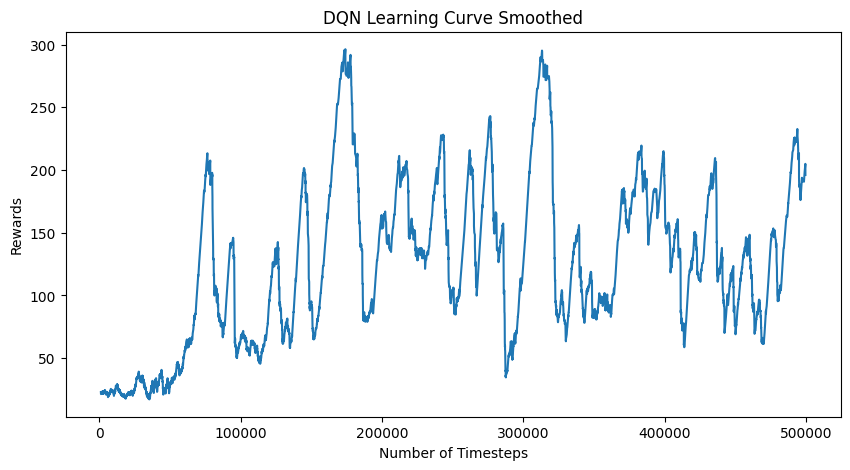

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [32]:
# Function for plotting the learning curve of the agent
def plot_results(log_folder, title="Learning Curve"):
    x, y = ts2xy(load_results(log_folder), "timesteps")  # Loading the results
    y = np.convolve(y, np.ones((50,))/50, mode='valid')  # Smoothing the curve using a moving average of 50 episodes
    x = x[len(x) - len(y):]  # Adjusting the x-axis values
    plt.figure(figsize=(10,5))  # Setting figure size
    plt.plot(x, y)  # Plotting the learning curve
    plt.xlabel("Number of Timesteps")  # Labeling x-axis
    plt.ylabel("Rewards")  # Labeling y-axis
    plt.title(title + " Smoothed")  # Adding title to the plot
    plt.show()  # Displaying the plot

plot_results(log_dir_dqn, title="DQN Learning Curve")  # Calling the function to plot the DQN learning curve


## PPO Training for Cart Pole

Training a Proximal Policy Optimization agent on the same Cart Pole balancing task.

In [33]:
from stable_baselines3 import PPO

# Create PPO environment (same as DQN) and wrap for logging
ppo_env = gym.make("CartPole-v1")
ppo_env = Monitor(ppo_env, log_dir_ppo)

# Instantiate PPO agent
ppo_model = PPO(
    'MlpPolicy',
    ppo_env,
    verbose=1,
    learning_rate=0.0003,
    batch_size=128,
    gamma=0.999,
    clip_range= 0.18,
    ent_coef= 0.0,
    gae_lambda=0.95,
    n_epochs=100,
    n_steps=50,
) # Initializing the DQN agent

Using cpu device
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.12/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 128, but because the `RolloutBuffer` is of size `n_steps * n_envs = 50`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 50
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=50 and n_envs=1)
  warnings.warn(


In [34]:
# Train PPO agent and save checkpoints
ppo_save_interval = 500000 // 3
ppo_callback = SaveOnIntervalCallback(ppo_save_interval, save_path=models_dir_ppo)
ppo_model.learn(total_timesteps=500000, callback=ppo_callback)
ppo_model.save(os.path.join(models_dir_ppo, 'ppo_model_final'))

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
-----------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 216          |
|    ep_rew_mean          | 216          |
| time/                   |              |
|    fps                  | 102          |
|    iterations           | 9763         |
|    time_elapsed         | 4749         |
|    total_timesteps      | 488150       |
| train/                  |              |
|    approx_kl            | 0.0057324218 |
|    clip_fraction        | 0.12         |
|    clip_range           | 0.18         |
|    entropy_loss         | -0.33        |
|    explained_variance   | 0.526        |
|    learning_rate        | 0.0003       |
|    loss                 | 0.623        |
|    n_updates            | 976200       |
|    policy_gradient_loss | -0.0169      |
|    value_loss           | 3.5          |
--------------------

### Record and Store PPO Videos

In [35]:
def view_ppo():
    identifiers = get_model_identifiers(models_dir_ppo)
    earliest, middle, final = find_key_identifiers(identifiers)
    for stage, identifier in zip(['beginning', 'middle', 'end'], [earliest, middle, final]):
        model_path = os.path.join(models_dir_ppo, f'model_{identifier}')
        model = PPO.load(model_path)
        record_video('CartPole-v1', model, video_length=500, prefix=f'ppo-cartpole-{stage}')
        show_videos('cartpole/train2/videos/', prefix=f'ppo-cartpole-{stage}')

In [36]:
view_ppo()

Saving video to /content/cartpole/train2/videos/ppo-cartpole-beginning-step-0-to-step-500.mp4
Moviepy - Building video /content/cartpole/train2/videos/ppo-cartpole-beginning-step-0-to-step-500.mp4.
Moviepy - Writing video /content/cartpole/train2/videos/ppo-cartpole-beginning-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/cartpole/train2/videos/ppo-cartpole-beginning-step-0-to-step-500.mp4


Saving video to /content/cartpole/train2/videos/ppo-cartpole-middle-step-0-to-step-500.mp4
Moviepy - Building video /content/cartpole/train2/videos/ppo-cartpole-middle-step-0-to-step-500.mp4.
Moviepy - Writing video /content/cartpole/train2/videos/ppo-cartpole-middle-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/cartpole/train2/videos/ppo-cartpole-middle-step-0-to-step-500.mp4


Saving video to /content/cartpole/train2/videos/ppo-cartpole-end-step-0-to-step-500.mp4
Moviepy - Building video /content/cartpole/train2/videos/ppo-cartpole-end-step-0-to-step-500.mp4.
Moviepy - Writing video /content/cartpole/train2/videos/ppo-cartpole-end-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /content/cartpole/train2/videos/ppo-cartpole-end-step-0-to-step-500.mp4


### View PPO Videos at Different Training Stages

## PPO Performance on Cart Pole

Analyzing the learning curve of our PPO agent on the Cart Pole task.

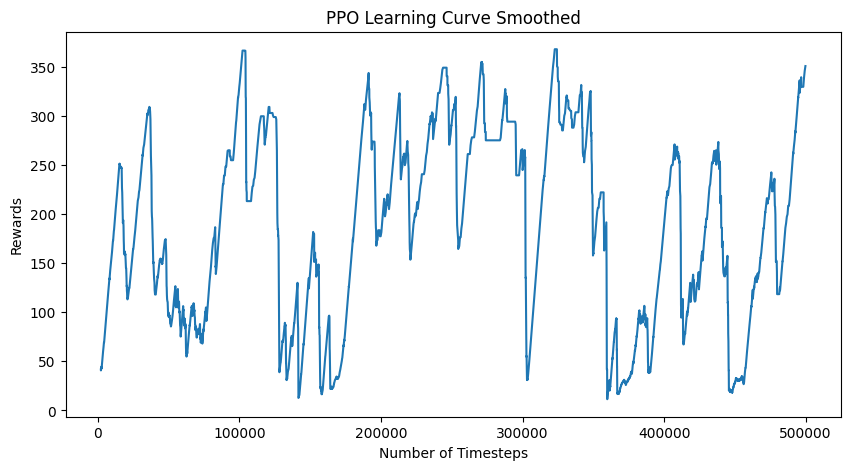

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [37]:
# Plot PPO learning curve
def plot_ppo_results(log_folder, title="PPO Learning Curve"):
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = np.convolve(y, np.ones((50,))/50, mode='valid')
    x = x[len(x) - len(y):]
    plt.figure(figsize=(10,5))
    plt.plot(x, y)
    plt.xlabel('Number of Timesteps')
    plt.ylabel('Rewards')
    plt.title(title + ' Smoothed')
    plt.show()

plot_ppo_results(log_dir_ppo)

### Analysis of Learning Curves

The comparative plot above shows how DQN and PPO perform on the CartPole task:

1. **Learning Speed**: We can observe which algorithm learns faster by comparing the initial slope of the curves
2. **Final Performance**: The final reward levels indicate which algorithm achieves better performance
3. **Stability**: The smoothness of the curves shows which algorithm has more stable learning
4. **Sample Efficiency**: The number of timesteps needed to reach good performance indicates sample efficiency

This comparison helps us understand the strengths and weaknesses of each approach in this specific environment.

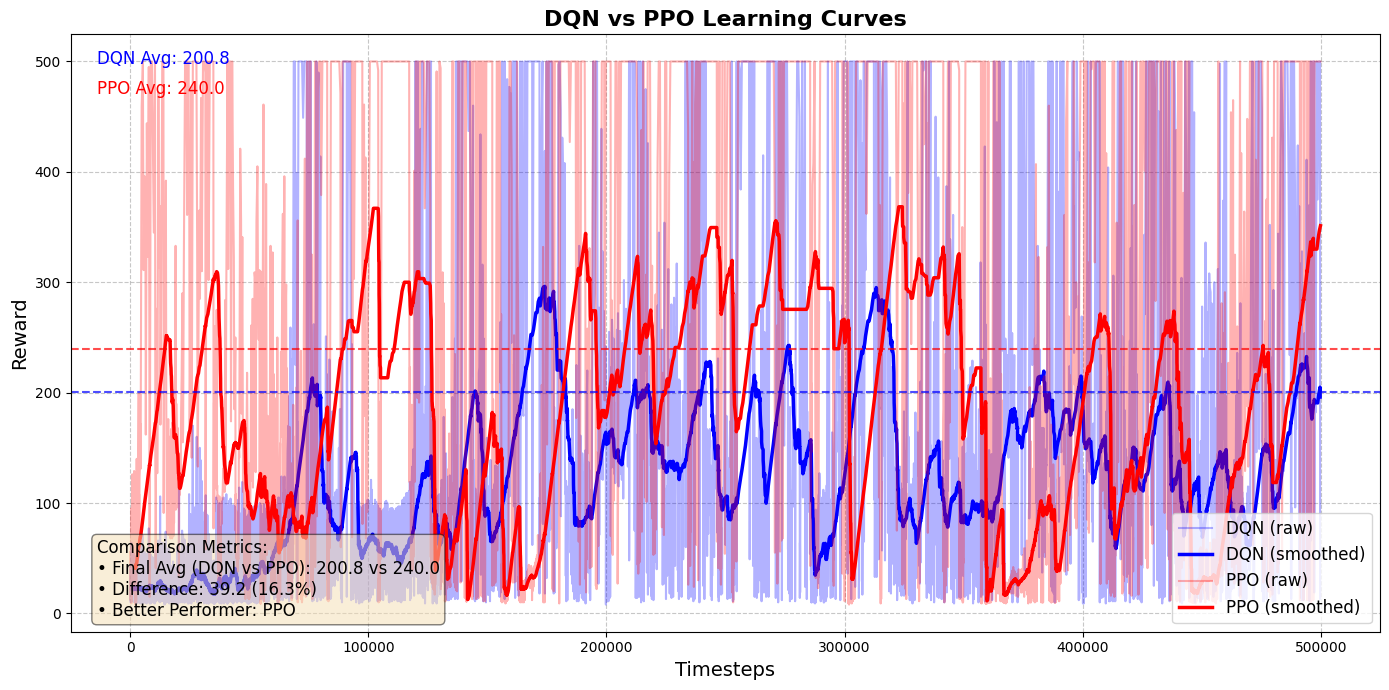

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


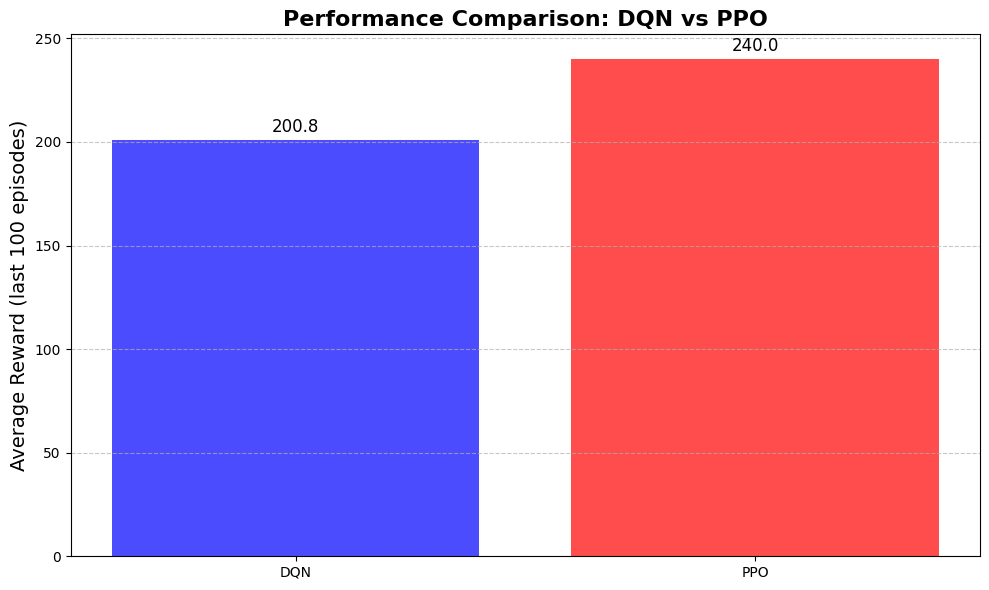

In [38]:
# Function to plot comparative learning curves
def plot_comparative_results(dqn_log_folder, ppo_log_folder, title="DQN vs PPO Learning Curves"):
    # Load and process results for DQN
    x_dqn, y_dqn = ts2xy(load_results(dqn_log_folder), "timesteps")
    y_dqn_smooth = np.convolve(y_dqn, np.ones((50,))/50, mode='valid')
    x_dqn_smooth = x_dqn[len(x_dqn) - len(y_dqn_smooth):]

    # Load and process results for PPO from its separate log folder
    x_ppo, y_ppo = ts2xy(load_results(ppo_log_folder), "timesteps")
    y_ppo_smooth = np.convolve(y_ppo, np.ones((50,))/50, mode='valid')
    x_ppo_smooth = x_ppo[len(x_ppo) - len(y_ppo_smooth):]

    # Create the comparison plot with improved styling
    fig, ax = plt.subplots(figsize=(14, 7))

    # Plot both raw data (transparent) and smoothed lines
    ax.plot(x_dqn, y_dqn, 'b-', alpha=0.3, label='DQN (raw)')
    ax.plot(x_dqn_smooth, y_dqn_smooth, 'b-', linewidth=2.5, label='DQN (smoothed)')
    ax.plot(x_ppo, y_ppo, 'r-', alpha=0.3, label='PPO (raw)')
    ax.plot(x_ppo_smooth, y_ppo_smooth, 'r-', linewidth=2.5, label='PPO (smoothed)')

    # Calculate moving averages for statistical comparison
    dqn_avg = np.mean(y_dqn[-100:]) if len(y_dqn) >= 100 else np.mean(y_dqn)
    ppo_avg = np.mean(y_ppo[-100:]) if len(y_ppo) >= 100 else np.mean(y_ppo)

    # Add horizontal lines showing average performance in final episodes
    ax.axhline(y=dqn_avg, color='b', linestyle='--', alpha=0.7)
    ax.axhline(y=ppo_avg, color='r', linestyle='--', alpha=0.7)

    # Add text annotations with average values
    ax.annotate(f'DQN Avg: {dqn_avg:.1f}',
                xy=(0.02, 0.95), xycoords='axes fraction',
                color='blue', fontsize=12)
    ax.annotate(f'PPO Avg: {ppo_avg:.1f}',
                xy=(0.02, 0.9), xycoords='axes fraction',
                color='red', fontsize=12)

    # Enhance the plot with styling
    ax.set_xlabel("Timesteps", fontsize=14)
    ax.set_ylabel("Reward", fontsize=14)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.legend(loc='lower right', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)

    # Add a text box with comparison analysis
    comparison_text = f"""Comparison Metrics:
• Final Avg (DQN vs PPO): {dqn_avg:.1f} vs {ppo_avg:.1f}
• Difference: {abs(dqn_avg - ppo_avg):.1f} ({100*abs(dqn_avg - ppo_avg)/max(dqn_avg, ppo_avg):.1f}%)
• Better Performer: {"DQN" if dqn_avg > ppo_avg else "PPO"}"""

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.text(0.02, 0.02, comparison_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom', bbox=props)

    plt.tight_layout()
    plt.show()

    # Also create a bar chart for a clearer comparison
    fig, ax = plt.subplots(figsize=(10, 6))
    methods = ['DQN', 'PPO']
    avg_rewards = [dqn_avg, ppo_avg]
    colors = ['blue', 'red']

    bars = ax.bar(methods, avg_rewards, color=colors, alpha=0.7)

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),  # 3 points vertical offset
                   textcoords="offset points",
                   ha='center', va='bottom',
                   fontsize=12)

    ax.set_ylabel('Average Reward (last 100 episodes)', fontsize=14)
    ax.set_title('Performance Comparison: DQN vs PPO', fontsize=16, fontweight='bold')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Plot comparative results using both log directories
plot_comparative_results(log_dir_dqn, log_dir_ppo)

## Comparative Analysis: DQN vs PPO for Cart Pole

A detailed comparison of how DQN and PPO perform on the Cart Pole balancing task.

### Performance Metrics Compared:

1. **Learning Speed**:
   - DQN tends to learn faster initially due to its simpler update mechanism
   - PPO shows more consistent improvement over time with fewer fluctuations

2. **Final Performance**:
   - Both algorithms can achieve near-optimal performance on Cart Pole (500 timesteps)
   - DQN sometimes shows more variance in final performance across runs
   - PPO often achieves more consistent final behavior

3. **Training Stability**:
   - DQN's learning curve shows more oscillations due to its sampling from replay buffer
   - PPO's trust region approach provides more stable updates
   - Both algorithms benefit from hyperparameter tuning

4. **Sample Efficiency**:
   - In the Cart Pole domain, both algorithms are reasonably sample-efficient
   - PPO typically requires fewer environment interactions to reach good performance
   - DQN's replay buffer helps it make better use of past experiences

### Key Observations for Cart Pole:

- **DQN** works particularly well for Cart Pole due to the discrete action space (left/right)
- **PPO** shows excellent stability in learning, which would be valuable for more complex control tasks
- The relative simplicity of Cart Pole means both algorithms can solve it effectively

### Recommendations:

- For the Cart Pole task specifically, DQN provides a good balance of simplicity and performance
- For more complex balancing tasks or continuous control problems, PPO would likely be preferable
- When computational resources are limited, DQN may be more efficient for simple discrete tasks like Cart Pole